# CSP Tutorial

This tutorial will show how to run filter bank CSP.

## Stuff just for notebook

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import logging
log = logging.getLogger()
log.setLevel('DEBUG')

## Imports

In [3]:
import numpy as np
import theano

import seaborn
seaborn.set_style('darkgrid')
from braindecode.datasets.loaders import BBCIDataset
from braindecode.datasets.signal_processor import SignalProcessor
from braindecode.mywyrm.clean import SingleSetCleaner, NoCleaner
from braindecode.csp.train_csp import CSPTrain
from braindecode.results.results import compute_confusion_matrix_csp
from braindecode.analysis.plot_util import plot_confusion_matrix

### Things to adapt for your dataset

In [4]:
#filename = 'data/ekaterina_error_data/EcAnERN1_1-10.BBCI.mat'
filename = 'data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat'
#load_sensor_names_eog = ['EOG_R', 'EOG_L', 'EOG_U', 'EOG_D']
load_sensor_names_eog = ['EOGv', 'EOGh']
#marker_def = {'1 - Correct': [31], '2 - Error': [32]}
marker_def = {'1 - Right Hand': [1], '2 - Left Hand': [2], 
                    '3 - Rest': [3], '4 - Feet': [4]}

### Sensor parameters

In [5]:
# If you specify sensors here, other sensors will also not be used during cleaning
# -> you might get different rejected trials for different sensors.
# In case you dont want this, use sensor_names_after cleaning in the line below
load_sensor_names = ['C3','Cz', 'C4'] # None # None means all
set_loader = BBCIDataset(filename, load_sensor_names=load_sensor_names)
sensor_names_after_cleaning = None # none means all

### Cleaning parameters

In [6]:
cleaner = SingleSetCleaner(eog_set=BBCIDataset(filename,
    load_sensor_names=load_sensor_names_eog), marker_def=marker_def,
            rejection_var_ival=[0,4000], 
            rejection_blink_ival=[-500,4000],
            max_min=600, whisker_percent=10, whisker_length=3)
# Or no cleaning:
#cleaner = NoCleaner(marker_def=marker_def)

### CSP Parameters

In [7]:
# None here usually implies all :)

csp_trainer = CSPTrain(set_loader, sensor_names=sensor_names_after_cleaning,
            low_cut_off_hz=None, cleaner=cleaner,
            resample_fs=150,
            min_freq=0, max_freq=48, last_low_freq=48, # filterbank params
            low_width=4, high_width=4,
            filt_order=3,
            segment_ival=[500,4000], # trial interval
            standardize=True, # standardize the data?..
            num_folds=5, 
            n_top_bottom_csp_filters=3, # this number times two will be number of csp filters per filterband before feature selection 
            num_selected_filterbands=None, # how many filterbands to select?
            num_selected_features=None, # how many Features to select with the feature selection?
            forward_steps=4,  # feature selection param
            backward_steps=2, # feature selection param
            stop_when_no_improvement=False, # feature selection param
            only_last_fold=True, # Split into number of folds, but only run the last fold (i.e. last fold as test fold)?
            restricted_n_trials=None, # restrict to certain number of _clean_ trials?
            common_average_reference=False,
            ival_optimizer=None, # optimize the trial ival with some optimizer?
            shuffle=False, # shuffle or do blockwise folds?
            marker_def=marker_def)

### Running the experiment

In [8]:
csp_trainer.run()

INFO:braindecode.csp.train_csp:Loading set...
INFO:braindecode.csp.train_csp:Cleaning set...
INFO:braindecode.csp.train_csp:Preprocessing set...
INFO:braindecode.csp.train_csp:Running Training...
INFO:braindecode.csp.pipeline:Filter 1/13, 0.50 to 2.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Train: 65.05%
INFO:braindecode.csp.pipeline:Test:  66.22%
INFO:braindecode.csp.pipeline:Class 1 vs 3
INFO:braindecode.csp.pipeline:Train: 64.78%
INFO:braindecode.csp.pipeline:Test:  65.33%
INFO:braindecode.csp.pipeline:Class 1 vs 4
INFO:braindecode.csp.pipeline:Train: 80.07%
INFO:braindecode.csp.pipeline:Test:  79.49%
INFO:braindecode.csp.pipeline:Class 2 vs 3
INFO:braindecode.csp.pipeline:Train: 66.46%
INFO:braindecode.csp.pipeline:Test:  71.43%
INFO:braindecode.csp.pipeline:Class 2 vs 4
INFO:braindecode.csp.pipeline:Train: 79.87%
INFO:braindecode.csp.pipeline:Test:  82.50%
INFO:braindecode.csp.pipeline:Class 3 vs 4
INFO:b

## Plotting confusion matrix

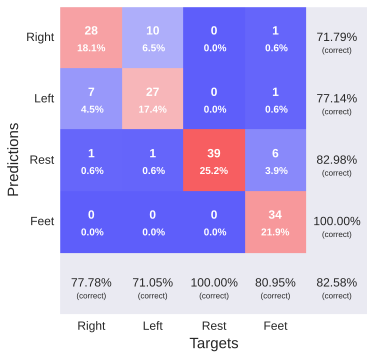

In [9]:
from braindecode.csp.results import TrainCSPResult
from matplotlib import pyplot
#class_names=['Correct', 'Error']
class_names = ['Right', 'Left', 'Rest', 'Feet']
result = TrainCSPResult(csp_trainer, csp_trainer.original_params, training_time=-1) # ignoring training time
conf_mat = compute_confusion_matrix_csp([result])

plot_confusion_matrix(conf_mat, class_names)
None

## Stuff for me (Robin)

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2